In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/sardata_small.zip -d /content/

In [3]:
import os
# import cv2
import torch

import pandas as pd
# import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import manual_seed
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
# from torchvision.io import decode_image
from PIL import Image
from torchvision import transforms
from torch import nn
# from tqdm import tqdm

In [4]:
CSV_FILE_PATH = './sardata_small.csv'
IMAGE_DIR_SAR = './sardata_small/s1'
IMAGE_DIR_COL = './sardata_small/s2'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
SEED = 42
manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"device: {DEVICE}")

device: cuda


In [5]:
data_df = pd.read_csv(CSV_FILE_PATH)

# train_df, test_df = train_test_split(data_df, test_size=0.15, random_state=SEED, shuffle=True, stratify=data_df['type'])
# print(train_df.groupby('type').count())
# print(test_df.groupby('type').count())

In [6]:
class SarColorDataset(Dataset):
    def __init__(self, data_df, image_dir_sar, image_dir_col, transform_sar=None, transform_col=None):
        self.data_df = data_df
        self.image_dir_sar = image_dir_sar
        self.image_dir_col = image_dir_col
        self.transform_sar = transform_sar
        self.transform_col = transform_col

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        row = self.data_df.iloc[index]
        label = row['type']

        image_path_sar = os.path.join(self.image_dir_sar, row['s1_image'])
        image_path_col = os.path.join(self.image_dir_col, row['s2_image'])

        # image_sar = decode_image(image_path_sar, mode='GRAY')
        # image_col = decode_image(image_path_col, mode='RGB')

        # image_sar = cv2.imread(image_path_sar, cv2.IMREAD_GRAYSCALE)
        # image_col = cv2.imread(image_path_col, cv2.IMREAD_COLOR_RGB)

        image_sar = Image.open(image_path_sar).convert('L')
        image_col = Image.open(image_path_col).convert('RGB')

        if self.transform_sar:
            image_sar = self.transform_sar(image_sar)

        if self.transform_col:
            image_col = self.transform_col(image_col)

        return image_sar, image_col, label

In [7]:
transform_sar = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,), inplace=False),
])

transform_col = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), inplace=False),
])

In [8]:
dataset = SarColorDataset(
    data_df=data_df,
    image_dir_sar=IMAGE_DIR_SAR,
    image_dir_col=IMAGE_DIR_COL,
    transform_sar=transform_sar,
    transform_col=transform_col,
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [9]:
class DownSample(nn.Module):
    def __init__(self, inp_c, out_c, kernel_size=4, stride=2, padding=1, use_bias=True, normalization='batch'):
        super(DownSample, self).__init__()

        self.down = nn.Sequential(
            nn.Conv2d(in_channels=inp_c, out_channels=out_c, kernel_size=kernel_size, stride=stride, padding=padding, bias=(not normalization) and use_bias),
        )

        if (normalization == 'batch'):
            self.down.append(nn.BatchNorm2d(num_features=out_c, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True))
        elif (normalization == 'instance'):
            self.down.append(nn.InstanceNorm2d(num_features=out_c, eps=1e-5, momentum=0.1, affine=False, track_running_stats=False))

        self.down.append(nn.LeakyReLU(negative_slope=0.2, inplace=False))

    def forward(self, x):
        x = self.down(x)
        return x

class UpSample(nn.Module):
    # def __init__(self, inp_c, out_c, kernel_size=4, stride=1, padding=0, use_bias = True, normalization='batch', apply_dropout=False, dropout_rate=0.5):
    def __init__(self, inp_c, out_c, kernel_size=4, stride=2, padding=1, use_bias = True, normalization='batch', apply_dropout=False, dropout_rate=0.5):
        super(UpSample, self).__init__()

        # self.up = nn.Sequential(
        #     nn.Upsample(scale_factor=2, mode='bilinear'),
        #     nn.ZeroPad2d((2,1,2,1)),
        #     nn.Conv2d(in_channels=inp_c, out_channels=out_c, kernel_size=kernel_size, stride=stride, padding=padding, bias=(not normalization) and use_bias),
        # )

        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_c, out_channels=out_c, kernel_size=kernel_size, stride=stride, padding=padding, bias=(not normalization) and use_bias),
        )

        if (normalization == 'batch'):
            self.up.append(nn.BatchNorm2d(num_features=out_c, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True))
        elif (normalization == 'isinstance'):
            self.up.append(nn.InstanceNorm2d(num_features=out_c, eps=1e-5, momentum=0.1, affine=False, track_running_stats=False))

        if apply_dropout:
            self.up.append(nn.Dropout(p=dropout_rate, inplace=False))

        self.up.append(nn.ReLU(inplace=False))

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return x

class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(Generator, self).__init__()

        self.down_stack = nn.ModuleList([
            DownSample(inp_c=in_channels, out_c=64, normalization=None),
            DownSample(inp_c= 64, out_c=128),
            DownSample(inp_c=128, out_c=256),
            DownSample(inp_c=256, out_c=512),
            DownSample(inp_c=512, out_c=512),
            DownSample(inp_c=512, out_c=512),
            DownSample(inp_c=512, out_c=512),
            DownSample(inp_c=512, out_c=512, normalization=None),
            ])

        self.up_stack = nn.ModuleList([
            UpSample(inp_c= 512, out_c=512), # removed dropout layers
            UpSample(inp_c=1024, out_c=512),
            UpSample(inp_c=1024, out_c=512),
            UpSample(inp_c=1024, out_c=512),
            UpSample(inp_c=1024, out_c=256),
            UpSample(inp_c= 512, out_c=128),
            UpSample(inp_c= 256, out_c= 64),
            ])

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ZeroPad2d((2,1,2,1)),
            nn.Conv2d(in_channels=128, out_channels=out_channels, kernel_size=4, stride=1, padding=0, bias=True),
            nn.Tanh()
        )

    def forward(self, x):

        skips = []
        for layer in self.down_stack:
            x = layer(x)
            skips.append(x)

        skips.pop()
        skips = skips[::-1]

        for layer, skip in zip(self.up_stack, skips):
            x = layer(x, skip)

        x = self.final(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            DownSample(inp_c=in_channels, out_c=64, normalization=None),
            DownSample(inp_c= 64, out_c=128),
            DownSample(inp_c=128, out_c=256),
            DownSample(inp_c=256, out_c=512, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=True),
        )

        # self.model = nn.Sequential(
        #     DownSample(inp_c=in_channels, out_c=64, normalization=None),
        #     DownSample(inp_c= 64, out_c=128),
        #     DownSample(inp_c=128, out_c=256, padding=0),
        #     nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=1, bias=True),
        # )

    def forward(self, sar_img, col_img):
        x = torch.cat([sar_img, col_img], dim=1)
        x = self.model(x)
        return x

In [10]:
generator = Generator(in_channels=1, out_channels=3).to(device=DEVICE)
discriminator = Discriminator(in_channels=4).to(device=DEVICE)

In [11]:
def initialize_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [12]:
generator.apply(initialize_weights)

Generator(
  (down_stack): ModuleList(
    (0): DownSample(
      (down): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownSample(
      (down): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): DownSample(
      (down): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): DownSample(
      (down): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

In [13]:
discriminator.apply(initialize_weights)

Discriminator(
  (model): Sequential(
    (0): DownSample(
      (down): Sequential(
        (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownSample(
      (down): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): DownSample(
      (down): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): DownSample(
      (down): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

In [14]:
# from torchsummary import summary

# summary(generator, input_size=(1, 256, 256))

In [15]:
# summary(discriminator, input_size=[(1, 256, 256), (3, 256, 256)])

In [16]:
# def rgb_to_lab(rgb):
#     '''
#     in:  tensor (b, c, h, w) [-1, 1]
#     out: tensor (b, c, h, w) [0, 1]
#     '''
#     rgb = (rgb + 1) / 2 # [0, 1] (b, c, h, w)

#     rgb = torch.where(rgb <= 0.04045, rgb / 12.92, ((rgb + 0.055) / 1.055) ** 2.4) # gamma correction

#     rgb_to_xyz_matrix = torch.tensor([
#         [0.4124564, 0.2126729, 0.0193339],
#         [0.3575761, 0.7151522, 0.1191920],
#         [0.1804375, 0.0721750, 0.9503041]
#         ])

#     xyz = torch.matmul(torch.permute(rgb, (0, 2, 3, 1)), rgb_to_xyz_matrix) #rgb to xyz colorspace [0, 1]
#     #                     (b, c, h, w) to (b, h, w, c)

#     # xyz = xyz * 100.0
#     # xyz = xyz / torch.tensor([95.047, 100.0, 108.883]) # divison by ref 2° D65 values

#     xyz = xyz / torch.tensor([0.95047, 1.0, 1.08883])

#     delta = 6/29
#     xyz = torch.where(xyz > delta**3, xyz**(1/3), (4/29) + (xyz / (3 * delta**2)))

#     x = xyz[:, :, :, 0]
#     y = xyz[:, :, :, 1]
#     z = xyz[:, :, :, 2]

#     l = ((116 * y) - 16) / 100.0            #    [0, 100] to [0, 1]
#     a = (500 * (x - y) + 128) / 255.0       # [-128, 127] to [0, 1]
#     b = (200 * (y - z) + 128) / 255.0       # [-128, 127] to [0, 1]

#     lab = torch.stack([l, a, b], dim=1)

#     return lab

In [17]:
bce_loss = nn.BCEWithLogitsLoss().to(device=DEVICE)
mae_loss = nn.L1Loss().to(device=DEVICE)

RGB_TO_Y_MATRIX = torch.tensor([
    [0.2126729],
    [0.7151522],
    [0.0721750]
], device=DEVICE)

def get_L(rgb):
    '''
    get L from CIELAB colorspace

    in:  tensor (b, c, h, w) [-1, 1]
    out: tensor (b, h, w) [0, 1]
    '''
    rgb = (rgb + 1) / 2 # [0, 1] (b, c, h, w)

    rgb = torch.where(rgb <= 0.04045, rgb / 12.92, ((rgb + 0.055) / 1.055) ** 2.4) # gamma correction

    global RGB_TO_Y_MATRIX
    y = torch.matmul(torch.permute(rgb, (0, 2, 3, 1)), RGB_TO_Y_MATRIX).squeeze(-1) # rgb to y from xyz colorspace [0, 1]
    #                     (b, c, h, w) to (b, h, w, c)

    y = torch.clamp(y, min=1e-6)  # Avoid negative or zero values

    delta = 6/29
    y = torch.where(y > delta**3, y**(1/3), (4/29) + (y / (3 * delta**2)))

    l = ((116 * y) - 16) / 100.0 # [0, 100] to [0, 1]

    return l

def generator_loss(generated, target, patch_fake, lambda_image=100.0, lambda_gradient=100.0):
    # generated_lab = rgb_to_lab(generated)
    # target_lab = rgb_to_lab(target)

    # gen_L = generated_lab[:, 0, :, :]
    # tar_L = target_lab[:, 0, :, :]

    gen_L = get_L(generated)
    tar_L = get_L(target)

    gen_L_h = torch.diff(gen_L, dim=1)
    tar_L_h = torch.diff(tar_L, dim=1)

    gen_L_w = torch.diff(gen_L, dim=2)
    tar_L_w = torch.diff(tar_L, dim=2)

    bce_loss_G = bce_loss(patch_fake, torch.full_like(patch_fake, fill_value=0.9, device=DEVICE))
    img_loss_G = mae_loss(generated, target)
    grd_loss_G = mae_loss(gen_L_h, tar_L_h) + mae_loss(gen_L_w, tar_L_w)

    loss_G = bce_loss_G + lambda_image * img_loss_G + lambda_gradient * grd_loss_G

    return loss_G, bce_loss_G.item(), img_loss_G.item(), grd_loss_G.item()

def discriminator_loss(patch_fake, patch_valid):
    valid_loss_D = bce_loss(patch_valid, torch.full_like(patch_valid, fill_value=0.9, device=DEVICE))
    fake_loss_D = bce_loss(patch_fake, torch.full_like(patch_fake, fill_value=0.1, device=DEVICE))

    loss_D = 0.5 * (valid_loss_D + fake_loss_D)

    return  loss_D, valid_loss_D.item(), fake_loss_D.item()

In [18]:
optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

In [19]:
def visualize_results(sar, fake, col):
    """
    Display SAR (grayscale), FAKE (RGB), and COL (RGB) images side by side.

    Args:
        sar (torch.Tensor): Grayscale image (1, H, W), range [-1, 1].
        fake (torch.Tensor): RGB image (3, H, W), range [-1, 1].
        col (torch.Tensor): RGB image (3, H, W), range [-1, 1].
    """
    def tensor_to_image(tensor, cmap=None):
        tensor = (tensor.clamp(-1, 1) + 1) / 2  # Normalize [-1,1] to [0,1]
        tensor = tensor.cpu().detach().numpy()  # Convert to NumPy
        if tensor.shape[0] == 1:  # Grayscale (1, H, W) -> (H, W)
            return tensor[0], "gray"
        return tensor.transpose(1, 2, 0), None  # RGB (3, H, W) -> (H, W, 3)

    images = [sar, fake, col]
    titles = ["SAR", "Generated", "Optical"]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, img, title in zip(axes, images, titles):
        img, cmap = tensor_to_image(img)
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)

    plt.show()

In [ ]:
START_EPOCH = 1
EPOCHS_TO_TRAIN = 100
LAST_EPOCH = START_EPOCH + EPOCHS_TO_TRAIN - 1
STEPS_PER_EPOCH = len(dataloader)
CHECKPOINT_DIR = '/content/drive/MyDrive/SAR_COLOR/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

loss_Gs = []
loss_Ds = []

for epoch in range(START_EPOCH, LAST_EPOCH + 1):

    generator.train()
    discriminator.train()

    epoch_loss_G = 0.0
    epoch_loss_D = 0.0

    # progress_bar = tqdm(enumerate(dataloader), desc=f'Epoch [{epoch:03}/{LAST_EPOCH:03}]', leave=True)

    print(f'\nEpoch [{epoch:03}/{LAST_EPOCH:03}]')
    print('-' * 52)

    # for i, (sar, col, _) in tqdm:
    for i, (sar, col, _) in enumerate(dataloader):

        sar = sar.to(DEVICE)
        col = col.to(DEVICE)

        fake = generator(sar)

        for param in discriminator.parameters():
            param.requires_grad = True

        optimizer_D.zero_grad()
        patch_valid = discriminator(sar, col)
        patch_fake = discriminator(sar, fake.detach())
        loss_D, valid_loss_D, fake_loss_D = discriminator_loss(patch_fake, patch_valid)
        loss_D.backward()
        # torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_D.step()

        for param in discriminator.parameters():
            param.requires_grad = False

        optimizer_G.zero_grad()
        patch_fake = discriminator(sar, fake)
        loss_G, bce_loss_G, img_loss_G, grd_loss_G = generator_loss(fake, col, patch_fake)
        loss_G.backward()
        # torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        optimizer_G.step()

        # progress_bar.set_postfix({
        #     "G Loss": f'{loss_G.item():.6f}',
        #     "D Loss": f'{loss_D.item():.6f}',
        # })

        # if (i + 1) % 1 == 0:
        if (i + 1) % (STEPS_PER_EPOCH // 5) == 0:
            print(
                f"Batch [{i+1:03}/{STEPS_PER_EPOCH:03}] | "
                f"Loss_D: {loss_D.item():8.6f} Loss_G: {loss_G.item():8.6f} | "
                f"Valid_D: {valid_loss_D:8.6f} Fake_D: {fake_loss_D:8.6f} | "
                f"BCE_G: {bce_loss_G:8.6f} Img_G: {img_loss_G:8.6f} Grd_G: {grd_loss_G:8.6f}"
            )

        loss_Gs.append(loss_G.item())
        loss_Ds.append(loss_D.item())

        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    epoch_loss_D /= STEPS_PER_EPOCH
    epoch_loss_G /= STEPS_PER_EPOCH

    print('-' * 52)
    print(
        f"Epoch [{epoch:03}/{LAST_EPOCH:03}] | "
        f"Loss_D: {epoch_loss_D:8.6f} Loss_G: {epoch_loss_G:8.6f} (Epoch Average)\n"
    )

    if epoch % 3 == 0:
        visualize_results(sar[0], fake[0], col[0])

    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item(),
    }

    if epoch % 5 == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch:03}.pth')
        torch.save(checkpoint, checkpoint_path)

        if epoch > 29:
            checkpoint_path_del = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch - 25:03}.pth')
            os.remove(checkpoint_path_del)



 Epoch [001/100]
 ----------------------------------------------------
 Batch [025/125] | Loss_D: 0.763464 Loss_G: 42.037685 | Valid_D: 0.781511 Fake_D: 0.745416 | BCE_G: 0.779636 Img_G: 0.304961 Grd_G: 0.107620
 Batch [050/125] | Loss_D: 0.715511 Loss_G: 43.401005 | Valid_D: 0.734385 Fake_D: 0.696638 | BCE_G: 0.791914 Img_G: 0.313168 Grd_G: 0.112923
 Batch [075/125] | Loss_D: 0.676090 Loss_G: 42.499313 | Valid_D: 0.694192 Fake_D: 0.657989 | BCE_G: 0.837530 Img_G: 0.302148 Grd_G: 0.114470
 Batch [100/125] | Loss_D: 0.597819 Loss_G: 41.933117 | Valid_D: 0.621691 Fake_D: 0.573948 | BCE_G: 0.943189 Img_G: 0.319734 Grd_G: 0.090165
 Batch [125/125] | Loss_D: 0.558342 Loss_G: 44.590477 | Valid_D: 0.577223 Fake_D: 0.539461 | BCE_G: 1.004962 Img_G: 0.323681 Grd_G: 0.112174
 ----------------------------------------------------
 Epoch [001/100] | Loss_D: 0.681997 Loss_G: 43.800459 (Epoch Average)
 
 
 Epoch [002/100]
 ----------------------------------------------------
 Batch [025/125] | Loss_

In [21]:
# from torchviz import make_dot

# dot = make_dot(loss_D, params=dict(discriminator.named_parameters()))
# dot.render("gradient_flow_D", format="png")
# dot.view()

# dot = make_dot(loss_G, params=dict(generator.named_parameters()))
# dot.render("gradient_flow_G", format="png")
# dot.view()

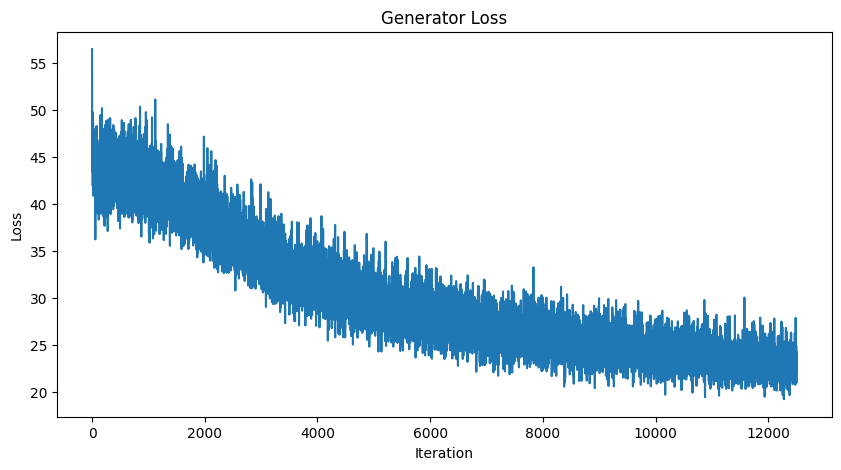

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(loss_Gs)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator Loss')
# plt.legend()
plt.show()

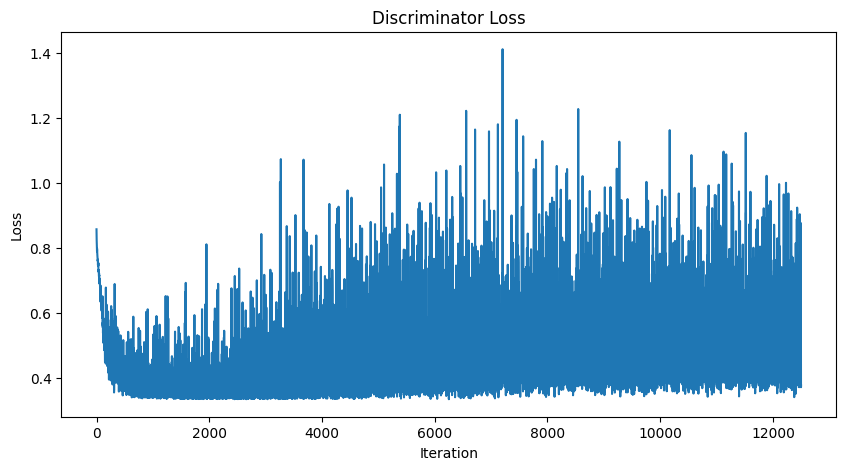

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(loss_Ds)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
# plt.legend()
plt.show()

In [24]:
from google.colab import runtime
runtime.unassign()